# Data Wrangling
In this notebook we'll obtain all of our data, arrange it how we want, and store it in the proper directories.

In [1]:
%run setup.ipynb
import copernicusmarine


# data_dir = Path('../data')
# output_dir = Path('../output')


tg_nc_dir = data_dir / 'tide_gauge_nc'

# Check if the directories exist, if not create them
for d in [data_dir, output_dir, tg_nc_dir]:
    if not d.exists():
        d.mkdir()

        

/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Retrieve Tide Gauge Data

We are interested in getting tide gauge and alitmetry data for the Hawaiian Islands (and surrounds) for 1993 through 2022.
Let's first establish where the tide gauges are by looking at the tide gauge dataset. We'll retrieve tide gauge data from the UHSLC (University of Hawaii Sea Level Center) fast-delivery dataset {cite:t}``. The fast-delivery data are released within 1-2 months of data collection and are subject only to basic quality control. 

We'll be retrieving the hourly data for our station group at from UHSLC, and saving this to our data directory so we don't have to download again.

In [2]:
# hawaii stations are: 
stationdict = {
    'Funafuti': '025',
    "Noku'alofa": '038'
}
stationdict.values()

station_group = 'Pacific Islands'

glue('station_group', station_group)

'Pacific Islands'

In [3]:
# # hawaii stations are: 
# stationdict = {
#     'Hilo': '060',
#     'Kawaihae': '552',
#     'Kahului': '059',
#     'Mokuoloe': '061',
#     'Honolulu': '057',
#     'Nawiliwili': '058',
#     'Johnston Island': '052',
#     'Midway Island': '050',
#     'Kaumalapau': '548',
#     'Barbers Point': '547',
#     'French Frigate Shoals': '014',
# }
# stationdict.values()

# station_group = 'Hawaiian Islands'

# glue('station_group', station_group)

````{margin}
```{note}
What about research quality data (RQD)? 
RQD undergo thorough and time-consuming QC, and are usually released 1-2 years after data is received. 
```
````

In [4]:
url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/" 
uhslc_ids = list(stationdict.values())

for uhslc_id in uhslc_ids:
    fname = f'h{uhslc_id}.nc' # h for hourly, d for daily

    path = os.path.join(data_dir, 'tide_gauge_nc',fname)

    if not os.path.exists(path):
        urlretrieve(os.path.join(url, fname), path) 
        print(f'Downloading {fname} from {url} to {path}')

Now we merge all the datasets. This can take a while.

In [5]:
data_dir

PosixPath('/Users/juliafiedler/Documents/SL_Hawaii_data/data')

```{caution}
In the following section I remove the trailing zero from the record-id of each tide gauge. This will propagate through everything!! 
```

In [6]:
# Load the data

import glob        
# Get a list of all .nc files in the data directory
# filenames should be in the format h*.nc with * being the station id in the stationdict
filenames = 'h' + pd.Series(stationdict.values()) + '.nc'
files = [glob.glob(str(data_dir / 'tide_gauge_nc' / file))[0] for file in filenames]


# Open the datasets
datasets = [xr.open_dataset(file) for file in files]

#merge in batches of 2 to avoid memory issues
batch_size = 2
merged_datasets = []

for i in range(0, len(datasets), batch_size):
    batch = datasets[i:i+batch_size]
    merged_batch = xr.merge(batch)
    merged_datasets.append(merged_batch)

#merge the merged datasets
rsl = xr.merge(merged_datasets)

# convert byte strings to normal strings
rsl['station_name'] = rsl['station_name'].astype(str)
rsl['station_country'] = rsl['station_country'].astype(str)
rsl['ssc_id'] = rsl['ssc_id'].astype(str)

# remove the trailing zero from each record_id
rsl['record_id'] =(rsl['record_id']/10).astype(int)
rsl

<xarray.Dataset> Size: 5MB
Dimensions:               (time: 303459, record_id: 2)
Coordinates:
  * time                  (time) datetime64[ns] 2MB 1990-06-20T21:00:00 ... 2...
  * record_id             (record_id) int64 16B 25 38
Data variables:
    sea_level             (record_id, time) float32 2MB nan nan ... 1.407e+03
    lat                   (record_id) float32 8B -8.525 -21.13
    lon                   (record_id) float32 8B 179.2 184.8
    station_name          (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
    station_country       (record_id) <U6 48B 'Tuvalu' 'Tonga'
    station_country_code  (record_id) float32 8B 798.0 776.0
    uhslc_id              (record_id) float32 8B 25.0 38.0
    gloss_id              (record_id) float32 8B 121.0 125.0
    ssc_id                (record_id) <U4 32B 'fong' 'nkfa'
    last_rq_date          (record_id) datetime64[ns] 16B 2021-12-31T22:59:59....
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-03-17T14:43:54Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [7]:
def get_MHHW_uhslc_datums(id, datumname, table=None):
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_mm_GMT.csv'
    datumtable = pd.read_csv(url)
    datum = datumtable[datumtable['Name'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    if table:
        return datum, datumtable
    else:
        return datum

```{note}
Should make something to include all datums here as well.
```

In [8]:
# add MHHW to the dataset
rsl['MHHW'] = xr.DataArray([get_MHHW_uhslc_datums(id, 'MHHW') for id in rsl['uhslc_id'].values], dims='record_id', coords={'record_id': rsl['record_id']})

rsl['MHHW'].attrs['units'] = 'mm'
rsl['MHHW'].attrs['long_name'] = 'Mean Higher High Water, rel. to station datum'

glue('datumname', 'MHHW')

# add MSL to the dataset
rsl['MSL'] = xr.DataArray([get_MHHW_uhslc_datums(id, 'MSL') for id in rsl['uhslc_id'].values], dims='record_id', coords={'record_id': rsl['record_id']})

rsl['MSL'].attrs['units'] = 'mm'
rsl['MSL'].attrs['long_name'] = 'Mean Sea Level, rel. to station datum'

# add MSL to the dataset
rsl['MLLW'] = xr.DataArray([get_MHHW_uhslc_datums(id, 'MLLW') for id in rsl['uhslc_id'].values], dims='record_id', coords={'record_id': rsl['record_id']})

rsl['MLLW'].attrs['units'] = 'mm'
rsl['MLLW'].attrs['long_name'] = 'Mean Sea Level, rel. to station datum'

glue('datumname', 'MSL')

'MHHW'

'MSL'

In [9]:
#round the time to the nearest hour
rsl['time'] = rsl['time'].dt.round('H')
rsl

/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/xarray/core/accessor_dt.py:161: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values


<xarray.Dataset> Size: 5MB
Dimensions:               (time: 303459, record_id: 2)
Coordinates:
  * time                  (time) datetime64[ns] 2MB 1990-06-20T21:00:00 ... 2...
  * record_id             (record_id) int64 16B 25 38
Data variables: (12/13)
    sea_level             (record_id, time) float32 2MB nan nan ... 1.407e+03
    lat                   (record_id) float32 8B -8.525 -21.13
    lon                   (record_id) float32 8B 179.2 184.8
    station_name          (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
    station_country       (record_id) <U6 48B 'Tuvalu' 'Tonga'
    station_country_code  (record_id) float32 8B 798.0 776.0
    ...                    ...
    gloss_id              (record_id) float32 8B 121.0 125.0
    ssc_id                (record_id) <U4 32B 'fong' 'nkfa'
    last_rq_date          (record_id) datetime64[ns] 16B 2021-12-31T22:59:59....
    MHHW                  (record_id) float64 16B 2.743e+03 1.525e+03
    MSL                   (record_id) float64 16B 2.05e+03 952.0
    MLLW                  (record_id) float64 16B 1.388e+03 368.0
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-03-17T14:43:54Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [10]:
#ensure rsl is netcdf4 format
rsl.to_netcdf(data_dir / 'rsl_pacific.nc',engine='netcdf4',mode='w')

rsl.close()



## Retrieve data from NOAA CO-OPS API


In [11]:
import json
url = "https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations.json"

response = requests.get(url)

# get a list of all the stations
stations = json.loads(response.text)

#from list of stations, get NOAA stations within the bounding box of UHSLC gauges
hawaii_stations = [station for station in stations['stations'] if station['lat'] >= rsl['lat'].min()-2 and station['lat'] <= rsl['lat'].max()+2 and station['lng'] >= -(360-rsl['lon'].min())-2 and station['lng'] <= -(360-rsl['lon'].max())+2]

#make a dictionary of all stations in hawaii with station name: station id
stationdictNOAA  = {station['name']: station['id'] for station in hawaii_stations}
stationdictNOAA 


{}

In [45]:
import requests
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

def fetch_data_chunk(stationID, start_date, end_date):
    # Format dates for the URL
    begin_date_str = start_date.strftime('%Y%m%d %H:%M')
    end_date_str = end_date.strftime('%Y%m%d %H:%M')
    
    # Create the URL
    url = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin_date_str}&end_date={end_date_str}&station={stationID}&datum=STND&product=water_level&units=metric&time_zone=gmt&format=json'
    
    # Request data from NOAA API
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        try:
            data = response.json()
            if 'data' in data:
                return data['data']
            else:
                # print(f"No 'data' key in response for {begin_date_str} to {end_date_str}: {data}")
                return []
        except ValueError as e:
            print(f"JSON decoding failed for {begin_date_str} to {end_date_str}: {e}")
            return []
    else:
        # print(f"Failed to fetch data for {begin_date_str} to {end_date_str}, status code: {response.status_code}")
        return []

def fetch_noaa_water_level_parallel(stationID, start_date, end_date):
    # Convert dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d %H:%M')
    end_date = datetime.strptime(end_date, '%Y%m%d %H:%M')
    
    # List to hold all data
    all_data = []
    
    # Generate date ranges in 31-day increments
    date_ranges = []
    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + timedelta(days=31)
        if current_end_date > end_date:
            current_end_date = end_date
        date_ranges.append((current_start_date, current_end_date))
        current_start_date = current_end_date + timedelta(seconds=1)
    
    total_ranges = len(date_ranges)
    
    # Fetch data in parallel
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_date_range = {executor.submit(fetch_data_chunk, stationID, start, end): (start, end) for start, end in date_ranges}
        completed_ranges = 0
        for future in as_completed(future_to_date_range):
            try:
                data_chunk = future.result()
                if data_chunk:
                    all_data.extend(data_chunk)
            except Exception as e:
                start, end = future_to_date_range[future]
                # print(f"Error fetching data for {start} to {end}: {e}")  #uncomment if you want to track progress
            
            completed_ranges += 1
            # print(f"Progress: {completed_ranges}/{total_ranges} chunks completed.") #uncomment if you want to track progress
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    if not df.empty:
        df['t'] = pd.to_datetime(df['t'])
        
        # Clean data: remove rows with empty 'v' values
        df = df[df['v'].str.strip() != '']
        
        # Convert 'v' to float
        df['v'] = df['v'].astype(float)
        
        # Remove duplicates
        df = df.drop_duplicates(subset='t')
        
        # Sort by time
        df = df.sort_values(by='t')
        
        # Create time series
        sea_level_ts = pd.Series(df['v'].values, index=df['t'])
        
        # Resample to hourly data
        sea_level_ts = sea_level_ts.resample('h').interpolate()
        
        # Ensure unique timestamps for xarray
        sea_level_ts = sea_level_ts[~sea_level_ts.index.duplicated(keep='first')]
        
        # Create xarray dataset with the correct dimension
        ds = xr.Dataset({'sea_level': ('t', sea_level_ts.values)}, coords={'t': sea_level_ts.index})

        # rename t to time
        ds = ds.rename({'t': 'time'})
        
        
        return ds
    else:
        print("No data fetched.")
        return xr.Dataset()


In [46]:

start_date = '19050101 00:00'
end_date = '20241231 00:00'

for station_name, station_id in stationdictNOAA.items():
    # check if we already have the data
    if os.path.exists(data_dir / f'tide_gauge_nc/noaa_{station_id}.nc'):
        #check last date in nc file
        dsOLD = xr.open_dataset(data_dir / f'tide_gauge_nc/noaa_{station_id}.nc')
        last_date = dsOLD['time'].values[-1]
        dsOLD.close()
        # if last date is after end_date, skip
        if pd.to_datetime(last_date) >= datetime.strptime(end_date, '%Y%m%d %H:%M'):
            print(f"Data for {station_name} already exists and is up to date, skipping")
            continue
        
        if pd.to_datetime(last_date) < datetime.strptime(end_date, '%Y%m%d %H:%M'):
            start_date = pd.to_datetime(last_date) + timedelta(hours=1)
            start_date = start_date.strftime('%Y%m%d %H:%M')
            print(f"Data for {station_name} already exists, will append from {start_date}")
    else:
        print(f"Fetching data for {station_name}")

    ds = fetch_noaa_water_level_parallel(station_id, start_date, end_date)
    ds['station_id'] = station_id
    ds['station_name'] = station_name
    ds['station_country'] = 'USA'
    ds['lat'] = float([station['lat'] for station in hawaii_stations if station['id'] == station_id][0])
    ds['lon'] = float([station['lng'] for station in hawaii_stations if station['id'] == station_id][0])

    # if the file already exists, append the new data
    if os.path.exists(data_dir / f'tide_gauge_nc/noaa_{station_id}.nc'):
        with xr.open_dataset(data_dir / f'tide_gauge_nc/noaa_{station_id}.nc') as dsOLD:
            dsNEW = xr.concat([dsOLD, ds], dim='time')
        dsNEW = dsNEW.drop_duplicates(dim='time')
        dsNEW.to_netcdf(data_dir / f'tide_gauge_nc/noaa_{station_id}.nc')
    else:
        ds.to_netcdf(data_dir /  f'tide_gauge_nc/noaa_{station_id}.nc')

Data for Nawiliwili already exists and is up to date, skipping
Data for Honolulu already exists and is up to date, skipping
Data for Pearl Harbor already exists and is up to date, skipping
Data for Mokuoloe already exists and is up to date, skipping
Data for Kahului, Kahului Harbor already exists and is up to date, skipping
Data for Kawaihae already exists and is up to date, skipping
Data for Hilo, Hilo Bay, Kuhio Bay already exists and is up to date, skipping
Data for Sand Island, Midway Islands already exists and is up to date, skipping


As before, we'll combine them into one dataset.

In [47]:
##COMMENTED OUT IF DATA HAS ALREADY BEEN COMBINED< TO FIX LATER
# Load the data

      
# Get a list of all noaa*.nc files in the data directory
files = glob.glob(os.path.join(data_dir,'tide_gauge_nc','noaa*.nc'))

# Open the datasets
datasets = [xr.open_dataset(file) for file in files]
# add the station_id as a coordinate
for ds in datasets:
    # ds = remove_time_dim(ds)
    ds.coords['station_id'] = ds['station_id']
rslNOAA = xr.concat(datasets, dim='station_id')

rslNOAA['sea_level'].attrs['units'] = 'm'
rslNOAA['sea_level'].attrs['long_name'] = 'Sea level, relative to station datum'


In [48]:
rslNOAA

<xarray.Dataset> Size: 19MB
Dimensions:          (time: 269593, station_id: 8)
Coordinates:
  * time             (time) datetime64[ns] 2MB 1994-03-31 ... 2024-12-31
  * station_id       (station_id) <U7 224B '1617760' '1619910' ... '1611400'
Data variables:
    sea_level        (station_id, time) float64 17MB nan nan nan ... 0.878 0.92
    station_name     (station_id) <U27 864B 'Hilo, Hilo Bay, Kuhio Bay' ... '...
    station_country  (station_id) <U3 96B 'USA' 'USA' 'USA' ... 'USA' 'USA'
    lat              (station_id) float64 64B 19.73 28.21 20.04 ... 21.3 21.95
    lon              (station_id) float64 64B -155.1 -177.4 ... -157.9 -159.4

Let's add some more metadata to this dataset, including MSL and MHHW datums for each gauge.

In [49]:
MHHW = np.zeros(len(rslNOAA['station_id']))
MSL = np.zeros(len(rslNOAA['station_id']))

for i in range(len(rslNOAA['station_id'])):
    url = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/'+ str(rslNOAA['station_id'][i].values) +'/datums.json?units=metric'
    
    response = requests.get(url)
    datums = json.loads(response.text)
    
    def extract_datum_value(data, datum_name):
        # Iterate through the datums list
        for datum in data.get('datums', []):
            # Check if the name matches the desired datum name
            if datum.get('name') == datum_name:
                # Return the value if found
                return datum.get('value')
        # Return None if the datum name is not found
        return None
    
    #extract the MHHW and MSL datums
    MHHW[i] = extract_datum_value(datums, 'MHHW')
    MSL[i] = extract_datum_value(datums, 'MSL')




In [50]:
rslNOAA['MHHW'] = xr.DataArray(MHHW, dims='station_id', coords={'station_id': rslNOAA['station_id']})
rslNOAA['MHHW'].attrs['units'] = 'm'
rslNOAA['MHHW'].attrs['long_name'] = 'Mean Higher High Water, rel. to station datum'

rslNOAA['MSL'] = xr.DataArray(MSL, dims='station_id', coords={'station_id': rslNOAA['station_id']})
rslNOAA['MSL'].attrs['units'] = 'm'
rslNOAA['MSL'].attrs['long_name'] = 'Mean Sea Level, rel. to station datum'


Change the longitude to match UHSLC 360-degree convention.

In [51]:
rslNOAA['lon'] = rslNOAA['lon'] + 360
rslNOAA

<xarray.Dataset> Size: 19MB
Dimensions:          (time: 269593, station_id: 8)
Coordinates:
  * time             (time) datetime64[ns] 2MB 1994-03-31 ... 2024-12-31
  * station_id       (station_id) <U7 224B '1617760' '1619910' ... '1611400'
Data variables:
    sea_level        (station_id, time) float64 17MB nan nan nan ... 0.878 0.92
    station_name     (station_id) <U27 864B 'Hilo, Hilo Bay, Kuhio Bay' ... '...
    station_country  (station_id) <U3 96B 'USA' 'USA' 'USA' ... 'USA' 'USA'
    lat              (station_id) float64 64B 19.73 28.21 20.04 ... 21.3 21.95
    lon              (station_id) float64 64B 204.9 182.6 204.2 ... 202.1 200.6
    MHHW             (station_id) float64 64B 1.927 1.206 1.444 ... 1.741 1.255
    MSL              (station_id) float64 64B 1.545 1.02 1.08 ... 1.412 0.949

In [52]:
#save rsl to the data directory
rslNOAA.to_netcdf(data_dir / 'rsl_hawaii_noaa.nc')

## Retrieve altimetry data 
We are using the global ocean gridded L4 [Sea Surface Heights and Derived Variables](https://doi.org/10.48670/moi-00148) from Copernicus. 

To download a subset of the global altimetry data, run get_CMEMS_data.py from this directory in a terminal with python >= 3.9 + copernicus_marine_client installed OR uncomment out the call to get_CMEMS_data and run it in this notebook. To read more about how to download the data from the Copernicus Marine Toolbox (new as of December 2023), visit https://help.marine.copernicus.eu/en/articles/7949409-copernicus-marine-toolbox-introduction. 

````{margin}
```{note}
You will need a username and password to access the CMEMS (Copernicus Marine Service) data if this is the first time running the client. To register for data access (free), visit https://data.marine.copernicus.eu/register.  
```
````

```{admonition} Large data download!
:class: warning
Getting errors on the code block below? Remember to uncomment "get_CMEMS_data()" to download. Note that if you change nothing in the function, it will download ~600 MB of data, which may take a long time!! You will only need to do this once. The dataset will be stored in the data directory you specify (which should be the same data directory we defined above).
```

In [29]:
# get the min and max lat and lon of rsl for altimetry data retrieval
minlat = float(rsl.lat.min().values)
maxlat = float(rsl.lat.max().values)
minlon = float(rsl.lon.min().values)
maxlon = float(rsl.lon.max().values)

In [12]:
def get_CMEMS_data(minlat, maxlat, minlon, maxlon, data_dir=data_dir):
        
    #maxlat = 15
    #minlat = 0
    #minlon = 125
    #maxlon = 140
    maxlat = maxlat+2
    minlat = minlat-2
    maxlon = maxlon+2
    minlon  = minlon-2
    
    start_date_str = "1993-01-01T00:00:00"
    end_date_str = "2024-12-31T23:59:59"
    data_dir = data_dir
    
    """
    Retrieves Copernicus Marine data for a specified region and time period.
    
    Args:
        minlon (float): Minimum longitude of the region.
        maxlon (float): Maximum longitude of the region.
        minlat (float): Minimum latitude of the region.
        maxlat (float): Maximum latitude of the region.
        start_date_str (str): Start date of the data in ISO 8601 format.
        end_date_str (str): End date of the data in ISO 8601 format.
        data_dir (str): Directory to save the retrieved data.
    
    Returns:
        str: The filename of the retrieved data.
    """
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D",
        variables=["sla"],
        minimum_longitude=minlon,
        maximum_longitude=maxlon,
        minimum_latitude=minlat,
        maximum_latitude=maxlat,
        start_datetime=start_date_str,
        end_datetime=end_date_str,
        output_directory=data_dir,
        output_filename="cmems_L4_SSH_0.125deg_" + start_date_str[0:4] + "_" + end_date_str[0:4] + "_pacific.nc"
    )
fname_cmems = 'cmems_L4_SSH_0.125deg_1993_2024_pacific.nc'

In [31]:
import copernicusmarine

# check if the file exists, if not, download it
if not os.path.exists(data_dir / fname_cmems):
    print('You will need to download the CMEMS data in a separate script')
    get_CMEMS_data(minlat, maxlat, minlon, maxlon, data_dir) #<<--- COMMENT OUT TO AVOID ACCIDENTAL DATA DOWNLOADS.
else:
    print('CMEMS data already downloaded, good to go!')

CMEMS data already downloaded, good to go!


Open up the CMEMS data and take a look. We will want to make an ASL dataset similar in structure to the RSL data so that we can easily compare the two.

In [13]:
# open the CMEMS data
ds = xr.open_dataset(data_dir / fname_cmems)

ds

<xarray.Dataset> Size: 941MB
Dimensions:    (time: 11488, latitude: 133, longitude: 77)
Coordinates:
  * latitude   (latitude) float32 532B -23.06 -22.94 -22.81 ... -6.688 -6.562
  * time       (time) datetime64[ns] 92kB 1993-01-01 1993-01-02 ... 2024-06-14
  * longitude  (longitude) float32 308B 177.3 177.4 177.6 ... 186.6 186.7 186.8
Data variables:
    sla        (time, latitude, longitude) float64 941MB ...
Attributes:
    source:                    Altimetry measurements
    references:                http://marine.copernicus.eu
    institution:               CLS, CNES
    history:                   2024-10-23 12:55:06Z: Creation
    contact:                   servicedesk.cmems@mercator-ocean.eu
    title:                     DT merged all satellites Global Ocean Gridded ...
    Conventions:               CF-1.6
    comment:                   Sea Surface Height measured by Altimetry and d...
    copernicusmarine_version:  2.0.1

In [14]:
rsl['sea_level'].mean()

<xarray.DataArray 'sea_level' ()> Size: 4B
array(1502.829, dtype=float32)

In [15]:
sla

NameError: name 'sla' is not defined

In [16]:
# Extract data for the nearest point to the tide gauge location that has data
sla = []
for lat, lon in zip(rsl['lat'].values, rsl['lon'].values):
    sla.append(ds['sla'].sel(
        longitude=lon, latitude=lat, method='nearest'
    ))

    #if the data is null, nan average over the nearest 4 points
    tol = 0.25
    if sla[-1].isnull().all():
        sla[-1] = ds['sla'].sel(
            longitude=slice(lon-360-tol, lon-360+tol), 
            latitude=slice(lat-tol, lat+tol)
        ).mean(dim=['latitude', 'longitude'])
        sla[-1]['latitude'] = np.mean(lat)
        sla[-1]['longitude'] = np.mean(lon)

sla = xr.concat(sla, dim='record_id')

# make sla a dataset with variables from rsl
sla = sla.to_dataset(name='sla')
sla['station_name'] = rsl['station_name']

# Creating lat_str and lon_str arrays with 'record_id' as their dimension
lat_str = [f'{np.abs(lat):.3f}\u00B0{"N" if lat > 0 else "S"}' for lat in sla.latitude.values]
lon_str = [f'{np.abs(lon):.3f}\u00B0{"E" if lon > 0 else "W"}' for lon in sla.longitude.values]  

# Convert lists to DataArrays with 'record_id' as their dimension
lat_str_da = xr.DataArray(lat_str, dims=['record_id'], coords={'record_id': rsl['record_id']})
lon_str_da = xr.DataArray(lon_str, dims=['record_id'], coords={'record_id': rsl['record_id']})

# Assign these DataArrays to the sla dataset
sla['lat_str'] = lat_str_da
sla['lon_str'] = lon_str_da

# add original data source to attributes
sla.attrs['original_data_source'] = 'CMEMS L4 SSH 0.125deg'
sla.attrs['title'] = ds.attrs['title']
sla.attrs['source_file'] = str(data_dir / fname_cmems)

# ensure latitude and longitude are coordinates associated with a location
sla = sla.set_coords(['latitude', 'longitude'])



sla

<xarray.Dataset> Size: 276kB
Dimensions:       (record_id: 2, time: 11488)
Coordinates:
    latitude      (record_id) float32 8B -8.562 -21.19
  * time          (time) datetime64[ns] 92kB 1993-01-01 ... 2024-06-14
    longitude     (record_id) float32 8B 179.2 184.8
  * record_id     (record_id) int64 16B 25 38
Data variables:
    sla           (record_id, time) float64 184kB -0.0846 -0.093 ... 0.1685
    station_name  (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
    lat_str       (record_id) <U8 64B '8.562°S' '21.188°S'
    lon_str       (record_id) <U9 72B '179.188°E' '184.812°E'
Attributes:
    original_data_source:  CMEMS L4 SSH 0.125deg
    title:                 DT merged all satellites Global Ocean Gridded SSAL...
    source_file:           /Users/juliafiedler/Documents/SL_Hawaii_data/data/...

In [17]:
#save sla to the data directory
sla.to_netcdf(data_dir / 'asl_pacific.nc')

## Processing
### Process the tide gauge data to match CMEMS
 Now we'll convert tide gauge data into a daily record for the POR in units of meters to match the CMEMS data. 
 
 The next code block:
 - extracts tide gauge data for the period 1993-2022
 - converts it to meters
 - removes any NaN values
 - resamples the data to daily mean
 - and normalizes it relative to the 1993-2012 epoch. 
 

The resulting data is stored in the variable 'rsl_daily' with units in meters.

In [18]:
# Next, let's establish a period of record from 1993-2022.
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2024,12,31)
#
# also save them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')



In [19]:
# Extract the data for the period of record (POR)
tide_gauge_data_POR = rsl['sea_level'].sel(time=slice(start_date, end_date))

# Convert to meters and drop any NaN values
tide_gauge_data_meters = tide_gauge_data_POR / 1000  # Convert from mm to meters
# tide_gauge_data_clean = tide_gauge_data_meters.dropna(dim='time')

# Resample the tide gauge data to daily mean before subtracting the epoch mean
tide_gauge_daily_avg = tide_gauge_data_meters.resample(time='1D').mean()


In [20]:
tide_gauge_daily_avg

<xarray.DataArray 'sea_level' (record_id: 2, time: 11688)> Size: 94kB
array([[      nan,       nan,       nan, ..., 2.173375 , 2.1851666,
        1.601    ],
       [1.07125  , 1.0758333, 1.4516667, ..., 1.04575  , 1.0560417,
        0.705    ]], dtype=float32)
Coordinates:
  * record_id  (record_id) int64 16B 25 38
  * time       (time) datetime64[ns] 94kB 1993-01-01 1993-01-02 ... 2024-12-31

### Normalize the tide gauge data relative to the 1993-2012 epoch

In [21]:
start_date

datetime.datetime(1993, 1, 1, 0, 0)

In [56]:

epoch_start, epoch_end = start_date, '2011-12-31'
epoch_daily_avg = tide_gauge_daily_avg.sel(time=slice(epoch_start, epoch_end))
epoch_daily_mean = epoch_daily_avg.mean(dim='time')




In [58]:
# ADJUSTMENTS FOR TIDE GAUGE #25
rid=25
arr = tide_gauge_daily_avg.sel(record_id=25)
if np.any(~np.isnan(arr)):
    t0 = arr['time'].where(~np.isnan(arr), drop=True).isel(time=0).values
    print(f"First non-NaN for record_id {rid}: {t0}")

# extend epoch-start and epoch-end to accommodate difference between t0 and Jan 1, 1993
# Convert dt.datetime to numpy.datetime64 for subtraction
tadjust = t0 - np.datetime64(dt.datetime(1993, 1, 1))

# Convert epoch_start and epoch_end to numpy.datetime64 for addition
epoch_start = np.datetime64(epoch_start) + tadjust
epoch_end = np.datetime64(epoch_end) + tadjust

epoch_daily_avg = tide_gauge_daily_avg.sel(time=slice(epoch_start, epoch_end))
epoch_daily_mean25 = epoch_daily_avg.sel(record_id=25).mean(dim='time')

First non-NaN for record_id 25: 1993-03-24T00:00:00.000000000


In [50]:
tide_gauge_data_POR

<xarray.DataArray 'sea_level' (record_id: 2, time: 280489)> Size: 2MB
array([[  nan,   nan,   nan, ..., 1611., 1514., 1601.],
       [1510., 1500., 1410., ...,  998.,  817.,  705.]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2MB 1993-01-01 ... 2024-12-31
  * record_id  (record_id) int64 16B 25 38
Attributes:
    long_name:  relative sea level
    units:      millimeters
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...

In [62]:
tide_gauge_daily_avg


<xarray.DataArray 'sea_level' (record_id: 2, time: 11688)> Size: 94kB
array([[      nan,       nan,       nan, ..., 2.173375 , 2.1851666,
        1.601    ],
       [1.07125  , 1.0758333, 1.4516667, ..., 1.04575  , 1.0560417,
        0.705    ]], dtype=float32)
Coordinates:
  * record_id  (record_id) int64 16B 25 38
  * time       (time) datetime64[ns] 94kB 1993-01-01 1993-01-02 ... 2024-12-31

In [64]:
# Subtract the epoch daily mean from the tide gauge daily average
rsl_daily = tide_gauge_daily_avg - epoch_daily_mean

rsl_daily.loc[dict(record_id=25)] = tide_gauge_daily_avg.sel(record_id=25) - epoch_daily_mean25

# Set the attributes of the rsl_daily data
rsl_daily.attrs = tide_gauge_data_POR.attrs
rsl_daily.attrs['units'] = 'm'

# add lat and lon to the dataset
rsl_daily['lat'] = rsl['lat']
rsl_daily['lon'] = rsl['lon']

# add the station name and country
rsl_daily['station_name'] = rsl['station_name']

# change the variable name to sea level anomaly
rsl_daily.name = 'rsl_anomaly'

# change long name of the variable to sea level anomaly
rsl_daily.attrs['long_name'] = 'Sea Level Anomaly'
rsl_daily.attrs['epoch'] = '1993-2012'

rsl_daily

<xarray.DataArray 'rsl_anomaly' (record_id: 2, time: 11688)> Size: 94kB
array([[        nan,         nan,         nan, ...,  0.16457486,
         0.17636657, -0.40780008],
       [ 0.08296943,  0.08755279,  0.46338618, ...,  0.05746949,
         0.06776118, -0.28328055]], dtype=float32)
Coordinates:
  * record_id     (record_id) int64 16B 25 38
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2024-12-31
    lat           (record_id) float32 8B -8.525 -21.13
    lon           (record_id) float32 8B 179.2 184.8
    station_name  (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2012

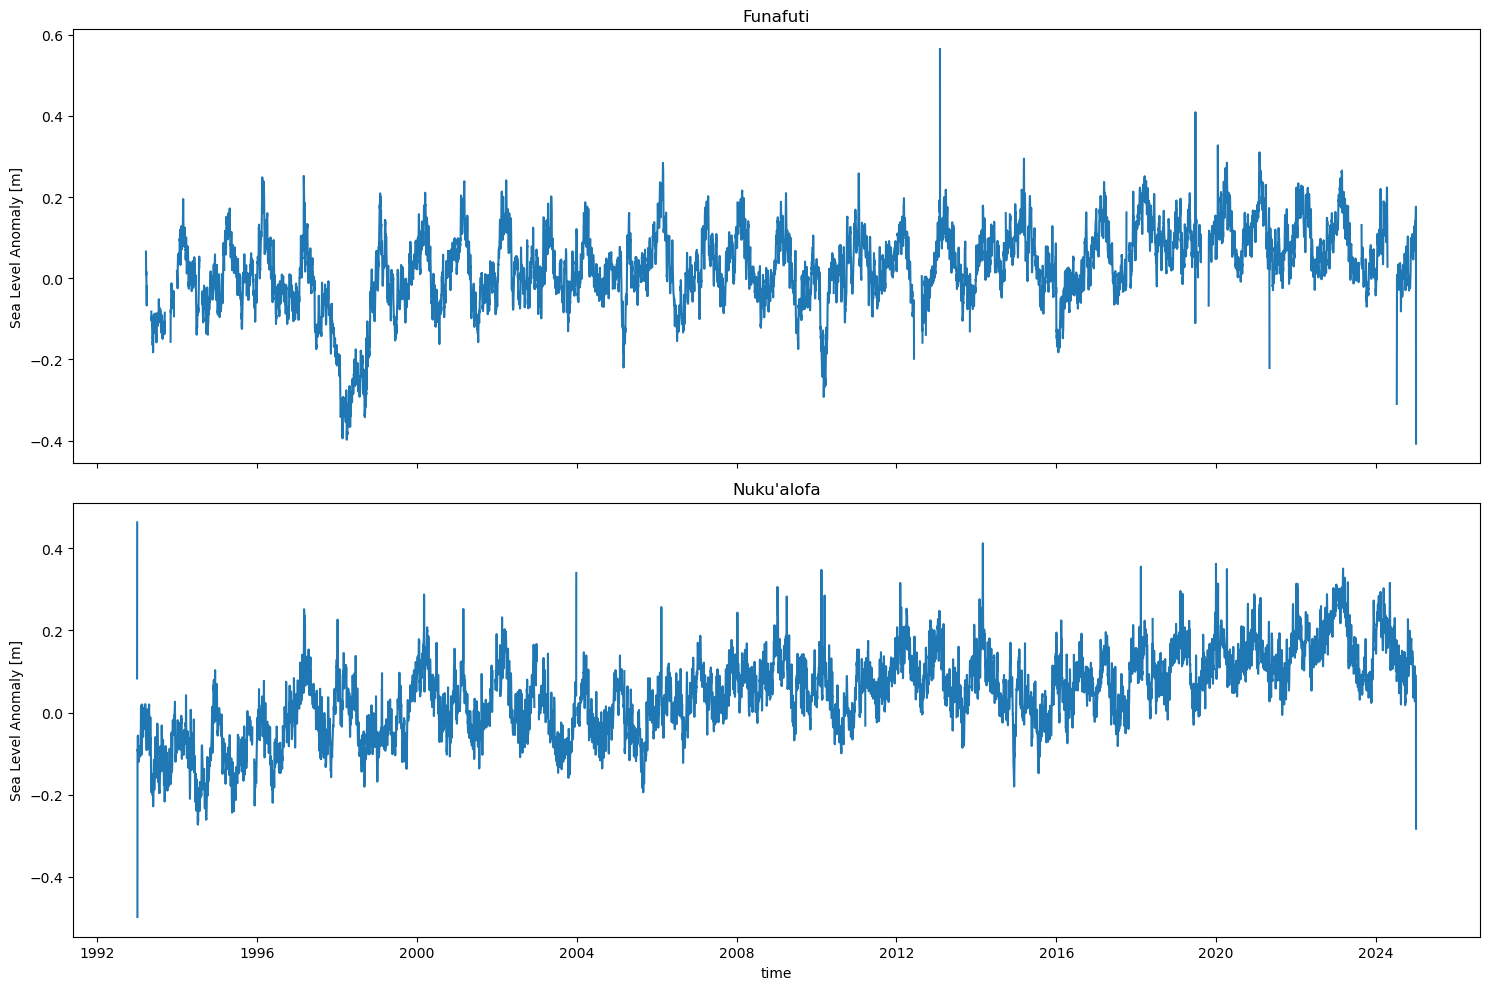

In [65]:
g = rsl_daily.plot(x='time', col='record_id', col_wrap=1, sharey=False, sharex=True, figsize=(15, 10))

# Use g.axs to iterate over the axes in the FacetGrid
for ax, rid in zip(g.axs.flat, rsl_daily.record_id):
    # Accessing the station_name coordinate for the current record_id directly
    station_name = rsl_daily.station_name.sel(record_id=rid).item()
    ax.set_title(station_name)

plt.show()


In [66]:
# Set tide gauge daily average relative to MHHW
rsl_daily_mhhw = tide_gauge_daily_avg - rsl['MHHW']/1000

# Set the attributes of the rsl_daily data
rsl_daily_mhhw.attrs = tide_gauge_data_POR.attrs
rsl_daily_mhhw.attrs['long_name'] = 'water level above MHHW'
rsl_daily_mhhw.attrs['units'] = 'm'
# add lat and lon to the dataset
rsl_daily_mhhw['lat'] = rsl['lat']
rsl_daily_mhhw['lon'] = rsl['lon']
# add the station name and country
rsl_daily_mhhw['station_name'] = rsl['station_name']

rsl_daily_mhhw.name = 'rsl_mhhw'
# save rsl_daily to the data directory
# rsl_daily_mhhw.to_netcdf(data_dir / 'rsl_daily_hawaii_mhhw.nc')


#combine the two datasets
rsl_daily_combined = xr.merge([rsl_daily, rsl_daily_mhhw])

rsl_daily_combined['storm_time'] = rsl_daily_combined['time']
rsl_daily_combined['storm_time'] = xr.DataArray(
    pd.to_datetime(rsl_daily_combined['storm_time'].values).to_series().apply(
        lambda x: x if x.month >= 5 else x - pd.DateOffset(years=1)
    ),
    dims=rsl_daily_combined['storm_time'].dims,
    coords=rsl_daily_combined['storm_time'].coords
)

#make storm time a coordinate
rsl_daily_combined = rsl_daily_combined.assign_coords(storm_time = rsl_daily_combined.storm_time)

# save rsl_daily_combined to the data directory
rsl_daily_combined.to_netcdf(data_dir / 'rsl_daily_pacific.nc')

In [31]:
rsl_daily_combined

<xarray.Dataset> Size: 468kB
Dimensions:       (record_id: 2, time: 11688)
Coordinates:
  * record_id     (record_id) int64 16B 25 38
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2024-12-31
    lat           (record_id) float32 8B -8.525 -21.13
    lon           (record_id) float32 8B 179.2 184.8
    station_name  (record_id) <U10 80B 'Funafuti' "Nuku'alofa"
    storm_time    (time) datetime64[ns] 94kB 1992-01-01 ... 2024-12-31
Data variables:
    rsl_anomaly   (record_id, time) float32 94kB nan nan nan ... 0.06159 -0.2895
    rsl_mhhw      (record_id, time) float64 187kB nan nan nan ... -0.469 -0.82
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2012

In [47]:
# rsl_daily_combined['storm_time'] = rsl_daily_combined['time']
# rsl_daily_combined['storm_time'] = xr.DataArray(
#     pd.to_datetime(rsl_daily_combined['storm_time'].values).to_series().apply(
#         lambda x: x if x.month >= 5 else x - pd.DateOffset(years=1)
#     ),
#     dims=rsl_daily_combined['storm_time'].dims,
#     coords=rsl_daily_combined['storm_time'].coords
# )

# #make storm time a coordinate
# rsl_daily_combined = rsl_daily_combined.assign_coords(storm_time = rsl_daily_combined.storm_time)

# # save rsl_daily_combined to the data directory
# rsl_daily_combined.to_netcdf(data_dir / 'rsl_daily_hawaii.nc')

# rsl_daily_combined


## Retrieve Climate Indices

In [70]:
def read_psl_url(url):
    response = requests.get(url)
    data = response.text
    # Split the data into lines
    lines = data.strip().split('\n')
    # Collect data lines until we encounter -9999
    data_lines = []
    for line in lines[1:]:  # Skip the first line if it's a header
        stripped_line = line.strip()
        if stripped_line == '':
            continue  # Skip empty lines
        # Detect possible footer lines (either starting with -99.9, -9999, or a textual footer)
        if stripped_line.startswith('-99.9') or stripped_line.startswith('-99.99') or stripped_line.startswith('-9999') or any(char.isalpha() for char in stripped_line):
            break  # Stop processing when footer is encountered
        # Add valid data lines to the list
        data_lines.append(line)
    # Combine data lines into a single string
    data_str = '\n'.join(data_lines)
    data_io = io.StringIO(data_str)
    return data_io

In [71]:
def read_psl_format(csvfile, varName):
    df = pd.read_csv(csvfile, sep='\s+', skiprows=1, skipfooter = 0,header=None, engine='python')
    CI = df.melt(id_vars=0, var_name='Month', value_name=varName)
    #Replace placeholder values with NaN
    CI.replace([-9.99, -9999, -9999.000, -999.99,-99.90,-99.99], np.nan, inplace=True)
    # Drop rows with NaN values
    CI = CI.dropna(subset=[varName])
    CI['time'] = pd.to_datetime({'year': CI[0], 'month': CI['Month'], 'day': 1})
    # Sort by 'time'
    CI = CI.sort_values('time').reset_index(drop=True)
    CI = CI[['time', varName]]

    return CI

In [72]:
def read_ncei_format(csvfile, varName):
    df = pd.read_csv(csvfile, sep='\s+', skiprows=0, skipfooter = 0,header=1, engine='python')
    ClimateIndex = df.melt(id_vars='Year', var_name='Month', value_name=varName)
    ClimateIndex['Month'] = ClimateIndex['Month'].map(month_mapping)
    # Replace placeholder values with NaN
    ClimateIndex.replace(99.99, np.nan, inplace=True)
    # Drop rows with NaN values
    ClimateIndex = ClimateIndex.dropna(subset=[varName])
    ClimateIndex['time'] = pd.to_datetime({'year': ClimateIndex['Year'], 'month': ClimateIndex['Month'], 'day': 1})
    # Sort by 'time'
    ClimateIndex = ClimateIndex.sort_values('time').reset_index(drop=True)
    ClimateIndex = ClimateIndex[['time', varName]]
    return ClimateIndex

In [73]:
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov':11, 'Dec':12
}

In [74]:
# Function to convert fraction of the year to datetime
def convert_fraction_to_date(date_float):
    # Extract year and fraction
    year = int(date_float)
    fraction = date_float - year
    
    # Calculate the total number of days in the year (consider leap years)
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
    
    # Calculate the day of the year based on the fraction
    day_of_year = int(np.floor(fraction * days_in_year)) + 1
    
    # Create a datetime object for January 1st of the given year
    start_date = pd.to_datetime(f"{year}-01-01")
    
    # Add the day offset to get the actual date
    return start_date + pd.to_timedelta(day_of_year - 1, unit='D')

## Pacific Meridional Mode

In [87]:
def retrieve_pmm(yearStart='1950',yearEnd='2024',data_dir=data_dir):

    plottingUrlBase = 'https://psl.noaa.gov/cgi-bin/data/climateindices/corr.pl?'
    plotSpecs1 = 'tstype1=45&custname1=&custtitle1=&tstype2=0&custname2=&custtitle2=&'
    timeRange = 'year1='+ yearStart + '&year2=' +  yearEnd + '&'
    plotSpecs2 = 'itypea=0&y1=&y2=&plotstyle=0&length=&lag=&iall=0&iseas=0&mon1=0&mon2=11&anom=0&climo1_yr1=&climo1_yr2=&climo2_yr1=&climo2_yr2=&Submit=Calculate+Results'

    plottingUrl = plottingUrlBase + plotSpecs1 + timeRange + plotSpecs2

    # access this plotting url, and then look for text that says "Data file", and then extract the url for the data file
    response = requests.get(plottingUrl)
    soup = BeautifulSoup(response.text, 'html.parser')
    data_url = soup.find('a', string='Data file')['href']

    # download the data
    response = requests.get('https://psl.noaa.gov/'+data_url)
    data = response.text

    data_io = io.StringIO(data)
    pmm = pd.read_csv(data_io, sep='\s+', header=None, names=["time", "PMM"])

    # remove rows with missing values
    pmm = pmm.dropna()

    # Apply the conversion function to the 'Date' column
    pmm['time'] = pmm['time'].apply(convert_fraction_to_date)

    # put this time as closest to first day of the month
    pmm['time'] = pmm['time'] + pd.DateOffset(days=15)
    pmm['time'] = pmm['time'].dt.to_period('M').dt.to_timestamp()

    # save to the data directory without the index
    pmm.to_csv(data_dir /'climate_indices' / 'pmm.csv', index=False)
    print('PMM data retrieved and saved to data directory')
    return pmm

## PDO: Pacific Decadal Oscillation

Monthly SST anomalies in the North Pacific Ocean. 

In [76]:
def retrieve_pdo_ncei(data_dir=data_dir):
    url = 'https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat'
    response = requests.get(url)
    data = response.text
    data_io = io.StringIO(data)
    PDO = read_psl_format(data_io, 'PDO')
    PDO.to_csv(data_dir / 'pdo.csv', index=False)
    print('PDO data retrieved and saved to data directory')

    return PDO


## BEST: Bivariate EnSo Timeseries 

This climate index combines the atmospheric component of ENSO (SOI) with the oceanic component (Nino 3.4 SST). 

For more info, see: https://psl.noaa.gov/people/cathy.smith/best/details.html
Smith, C.A. and P. Sardeshmukh, 2000, The Effect of ENSO on the Intraseasonal Variance of Surface Temperature in Winter., International J. of Climatology, 20 1543-1557.

In [77]:
def retrieve_climateIndex(ClimateIndex, data_dir=data_dir):
    PSLurlBase = 'https://psl.noaa.gov/data/'

    # Define the URL based on the ClimateIndex
    if ClimateIndex in ['TNA', 'ONI','PNA']:
        url = PSLurlBase + 'correlation/' + ClimateIndex.lower() + '.data'
    
    elif ClimateIndex in ['AAO']:
        url = PSLurlBase + 'timeseries/month/data/' + ClimateIndex.lower() + '.data'

    elif ClimateIndex == 'AO':
        url = PSLurlBase + 'timeseries/month/data/' + ClimateIndex.lower() + '.long.data'

    elif ClimateIndex == 'DMI':
        url = 'https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/dmieast.had.long.data'

    elif ClimateIndex == 'BEST':
        url = PSLurlBase + 'correlation/censo.data'
    
    elif ClimateIndex == 'PDO':
        url = 'https://psl.noaa.gov/pdo/data/pdo.timeseries.sstens.data'

    else:
        raise ValueError(f"ClimateIndex '{ClimateIndex}' is not recognized")
    
    print(f"Retrieving data from: {url}")

    # Fetch and format the data
    data_io = read_psl_url(url)
    climate_data = read_psl_format(data_io, ClimateIndex)

    # Save the data to a CSV file
    output_file = data_dir / 'climate_indices' / (ClimateIndex.lower() + '.csv')
    climate_data.to_csv(output_file, index=False)
    print(f"{ClimateIndex} data retrieved and saved to {output_file}")

    return climate_data

In [88]:
ONI = retrieve_climateIndex('ONI')
TNA = retrieve_climateIndex('TNA')
PNA = retrieve_climateIndex('PNA')
# AAO = retrieve_climateIndex('AAO')
AO = retrieve_climateIndex('AO')
# DMI = retrieve_climateIndex('DMI')
BEST = retrieve_climateIndex('BEST')
PMM = retrieve_pmm()
PDO = retrieve_climateIndex('PDO')

Retrieving data from: https://psl.noaa.gov/data/correlation/oni.data
ONI data retrieved and saved to /Users/jfiedler/Documents/SL_Hawaii_data/data/climate_indices/oni.csv
Retrieving data from: https://psl.noaa.gov/data/correlation/tna.data
TNA data retrieved and saved to /Users/jfiedler/Documents/SL_Hawaii_data/data/climate_indices/tna.csv
Retrieving data from: https://psl.noaa.gov/data/correlation/pna.data
PNA data retrieved and saved to /Users/jfiedler/Documents/SL_Hawaii_data/data/climate_indices/pna.csv
Retrieving data from: https://psl.noaa.gov/data/timeseries/month/data/ao.long.data
AO data retrieved and saved to /Users/jfiedler/Documents/SL_Hawaii_data/data/climate_indices/ao.csv
Retrieving data from: https://psl.noaa.gov/data/correlation/censo.data
BEST data retrieved and saved to /Users/jfiedler/Documents/SL_Hawaii_data/data/climate_indices/best.csv
PMM data retrieved and saved to data directory
Retrieving data from: https://psl.noaa.gov/pdo/data/pdo.timeseries.sstens.data
PDO

In [79]:
# List of all DataFrames and their corresponding names
CIs = {
    'BEST': BEST,
    # 'DMI': DMI,
    'AO': AO,
    # 'AAO': AAO,
    'PNA': PNA,
    'TNA': TNA,
    'ONI': ONI,
    'PDO': PDO,
    'PMM': PMM
}

# Start with the first DataFrame (BEST in this case)
merged_CI = CIs['BEST']

# Loop through the rest of the DataFrames and merge them on 'time'
for name, df in CIs.items():
    if name != 'BEST':
        merged_CI = pd.merge(merged_CI, df, on='time', how='outer')



In [80]:
# truncate to 1990 through 2024
merged_CI = merged_CI[(merged_CI['time'] >= '1990-01-01') & (merged_CI['time'] <= '2024-12-31')]

#replace placeholder values with NaN
merged_CI.replace([-999], np.nan, inplace=True)

merged_CI.to_csv(data_dir / 'climate_indices' / 'climate_indices.csv', index=False)


In [81]:
# get standard deviation of the climate indices
merged_CI = pd.read_csv(data_dir / 'climate_indices' / 'climate_indices.csv')

# Calculate the standard deviation of each column except 'time'
std_dev = merged_CI.drop(columns='time').std()

# calculate the mean of each column except 'time'
mean = merged_CI.drop(columns='time').mean()

In [82]:
mean

BEST    0.055757
AO      0.061043
PNA    -0.014190
TNA     0.317667
ONI     0.010524
PDO    -0.434321
PMM     0.102714
dtype: float64

In [83]:
# normalize the climate indices such that they have a standard deviation of 1
merged_CI_norm = merged_CI.copy()
for col in merged_CI_norm.columns[1:]:
    # normalize the column by subtracting the mean and dividing by the standard deviation
    merged_CI_norm[col] = merged_CI_norm[col] - mean[col]
    merged_CI_norm[col] = merged_CI_norm[col] / std_dev[col]

merged_CI_norm['time'] = pd.to_datetime(merged_CI_norm['time'])

#save to the data directory
merged_CI_norm.to_csv(data_dir / 'climate_indices' / 'climate_indices_norm.csv', index=False)

    

In [84]:
merged_CI_norm

,time,BEST,AO,PNA,TNA,ONI,PDO,PMM
0,1990-01-01,0.087899,0.934306,-1.126112,-1.004746,0.151401,0.110996,0.504310
1,1990-02-01,1.001934,3.320871,-2.895133,-1.055278,0.233254,-0.425285,-0.069556
2,1990-03-01,0.516936,2.911348,0.056724,-0.903681,0.315107,-0.315488,0.507299
3,1990-04-01,0.246456,1.807027,-0.634136,-0.651021,0.326800,0.473961,0.498333
4,1990-05-01,-0.322483,0.876655,0.297479,-0.474159,0.326800,0.397739,0.333944
...,...,...,...,...,...,...,...,...
415,2024-08-01,NaN,1.215604,-1.073774,2.052443,-0.140932,-1.405291,0.794232
416,2024-09-01,NaN,NaN,1.145353,1.825049,-0.257865,-2.110351,0.770321
417,2024-10-01,NaN,NaN,0.224206,1.799783,-0.316332,-2.414335,0.363833
418,2024-11-01,NaN,NaN,0.067192,1.673453,-0.444958,-2.219241,0.097822


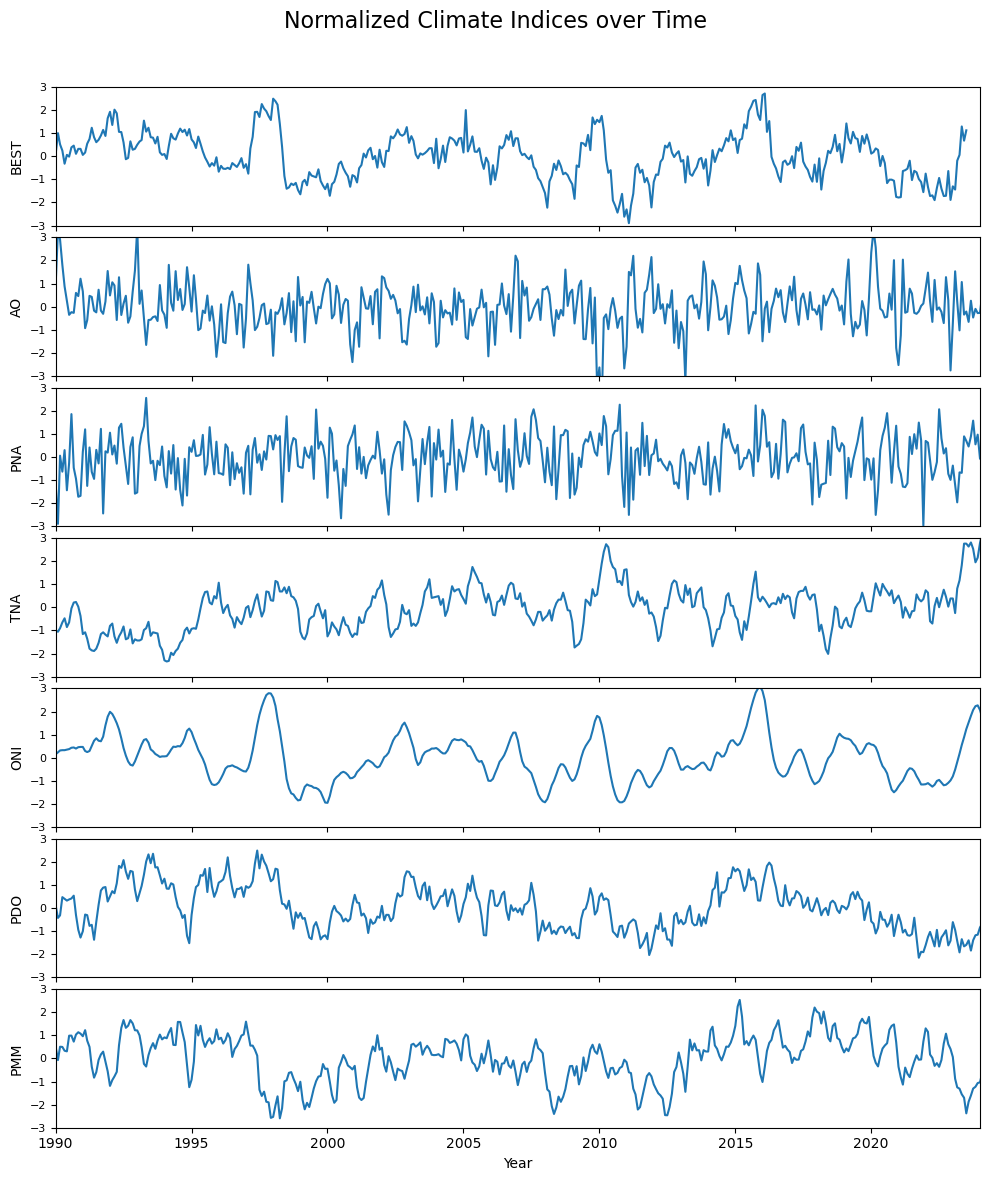

In [85]:
import matplotlib.dates as mdates

indices = merged_CI_norm.columns[1:]

# Adjusting the x-axis limits to range from 1993 to 2024
fig, axs = plt.subplots(len(indices), 1, figsize=(10, 12), sharex=True)

# Loop through each index and its corresponding subplot
for i, index in enumerate(indices):
    axs[i].plot(merged_CI_norm['time'], merged_CI_norm[index], label=index)
    axs[i].set_ylabel(index)  
    axs[i].set_ylim(-3, 3)  # Set y-axis limits to
    axs[i].tick_params(axis='y', labelsize=8)  # Set smaller tick size for y-axis

# Set the x-axis label only for the last subplot
axs[-1].set_xlabel('Year')

# Set x-axis major ticks to every 5 years and limit to 1993 to 2024
axs[-1].set_xlim(pd.Timestamp('1990-01-01'), pd.Timestamp('2024-01-01'))
axs[-1].xaxis.set_major_locator(mdates.YearLocator(5))
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set a common title for the figure
fig.suptitle('Normalized Climate Indices over Time', fontsize=16)

# Adjust spacing between subplots, reducing vertical gaps
plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=0.5)


